# Wellbeing Police

From various subreddit, we have scraped close to 4000 posts. The subreddits include "r/SuicideWatch", "r/BipolarReddit", "r/Anxiety", "r/AnxietyDepression", "r/Depression", and "r/Happy". Each of the subreddit posts currently sitting within its own csv file. We will see what are the fields that are consistent across the CSV files and choose those applicable. Clean up the data, removed the columns not needed. 

As all the scrapes was created from the same script, the columns of the resulting csv are same across the files. 
We will proceed to label them according to the subreddit they came from and combine them into a single dataframe.

In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import numpy as np
import pandas as pd
import glob
import os
import spacy
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.vocab import GloVe


from src.utils import color_func, get_mask, search,text_normalization
from src.nn import *

### Data Combination and Labeling

We retrieved posts in “Hot” section from various subreddits:
`r/ptsd`,`r/Anxiety`,`r/SuicideWatch`,`r/depression`,`r/BipolarReddit`,`r/schizophrenia`,`r/EDAnonymous`,`r/EatingDisorders`

In [57]:
path = "./reddit/csvs/"
all_csvs = glob.glob(os.path.join(path, "*.csv"))

all_dfs = []
for filename in all_csvs:
    df = pd.read_csv(filename, index_col=None, header=0)
    df = df[["title", "subreddit", "body"]]
    df = df[2:]
    
    # ## manually remove irrelevant pinned posts
    # if df.iloc[0].subreddit in ["ptsd",'Anxiety',"SuicideWatch",'EDAnonymous']: 
    #     df=df[2:]
    # if df.iloc[0].subreddit in ['BipolarReddit','schizophrenia','EatingDisorders']:
    #     df=df[1:]
        
    all_dfs.append(df)

# main_df = pd.concat(all_dfs)
# print(main_df.shape)
# main_df = main_df.drop_duplicates()
# print(main_df.shape)
# main_df = main_df.dropna()
# print(main_df.shape)
# main_df.head()


# main_df["body"] = main_df["title"] + " " + main_df["body"]
# main_df = main_df.drop_duplicates()
# print(main_df.shape)
# main_df = main_df.dropna()
# print(main_df.shape)
# main_df.head()

main_df = pd.concat(all_dfs)
print(main_df.shape)
main_df = main_df.fillna('')
main_df["body"] = main_df["title"] + " " + main_df["body"]
main_df = main_df.drop_duplicates()
print(main_df.shape)
main_df = main_df.dropna()
print(main_df.shape)
main_df.head()


main_df = main_df.drop_duplicates()
print(main_df.shape)
main_df = main_df.dropna()
print(main_df.shape)
main_df.head()


(34785, 3)
(24291, 3)
(24291, 3)
(24291, 3)
(24291, 3)


,title,subreddit,body
2,Just swallowed half a bottle of Tylenol waitin...,SuicideWatch,Just swallowed half a bottle of Tylenol waitin...
3,I just want to be normal,SuicideWatch,I just want to be normal I’ve been depressed/s...
4,I am really struggling. I need help. Anything ...,SuicideWatch,I am really struggling. I need help. Anything ...
5,i discontinued my own suicide attempt,SuicideWatch,i discontinued my own suicide attempt i don‘t ...
6,"I always look outside of the window, dreaming ...",SuicideWatch,"I always look outside of the window, dreaming ..."


A few of the subreddit is indicating the same underlying mental problems, we proceed to add an attribute such that these minor differentiation will be grouped for better and easier identification.

<Axes: title={'center': 'Class Counts'}>

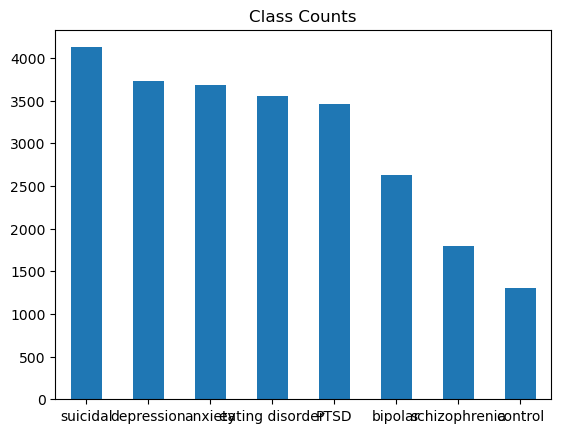

In [58]:
sub_problem_mapping = {
    "ptsd": "PTSD",
    "CPTSD": "PTSD",
    "Anxiety": "anxiety",
    "Anxietyhelp": "anxiety",
    "SuicideWatch": "suicidal",
    "selfharm": "suicidal",
    "depression": "depression",
    "depression_help": "depression", 
    "BipolarReddit": "bipolar", 
    "bipolar": "bipolar",
    "schizophrenia": "schizophrenia",
    "EDAnonymous": "eating disorder",
    "EatingDisorders": "eating disorder",
    "happy": "control",
    "MadeMeSmile": "control"
}

main_df["problem"] = [sub_problem_mapping[s] for s in main_df["subreddit"]]
main_df.head()
main_df["problem"].value_counts().plot.bar(rot=0, title="Class Counts")

#NEED TO DECIDE whether need to drop control.

In [59]:
df_PTSD = main_df[main_df['problem'] == 'PTSD']
df_anxiety = main_df[main_df['problem'] == 'anxiety']
df_suicidal = main_df[main_df['problem'] == 'suicidal']
df_depression = main_df[main_df['problem'] == 'depression']
df_bipolar = main_df[main_df['problem'] == 'bipolar']
df_schizophrenia = main_df[main_df['problem'] == 'schizophrenia']
df_eating_disorder = main_df[main_df['problem'] == 'eating disorder']
df_control = main_df[main_df['problem'] == 'control']

df_PTSD = df_PTSD[:1500]
df_anxiety = df_anxiety[:1500]
df_suicidal = df_suicidal[:1500]
df_depression = df_depression[:1500]
df_bipolar = df_bipolar[:1500]
df_schizophrenia = df_schizophrenia[:1500]
df_eating_disorder = df_eating_disorder[:1500]
# df_control = df_control[:1500]
all_dfs = []
all_dfs.append(df_PTSD)
all_dfs.append(df_anxiety)
all_dfs.append(df_suicidal)
all_dfs.append(df_depression)
all_dfs.append(df_bipolar)
all_dfs.append(df_schizophrenia)
all_dfs.append(df_eating_disorder)
all_dfs.append(df_control)
main_df = pd.concat(all_dfs)

<Axes: title={'center': 'Class Counts'}>

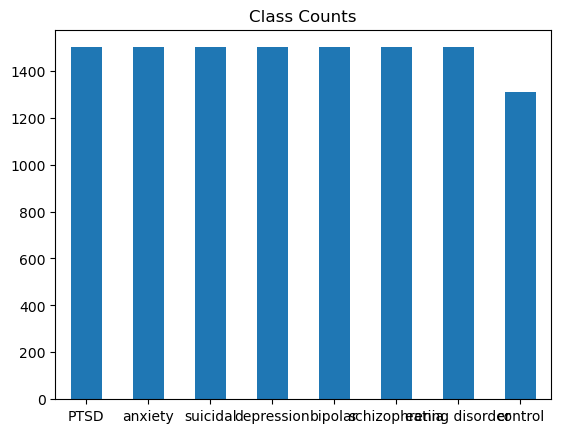

In [60]:
main_df["problem"].value_counts().plot.bar(rot=0, title="Class Counts")

In [61]:

# Normalization codes from the notebook
# Note that we did not include removal of words in brackets as well as odd characters as
# these may denote some emotion (anger for instance may lead to multiple !!!). 
def normalizer(s):
    s = s.lower()                                                   # Lowercase whole sentence
    s = re.sub(r'\s+', ' ', s)                                      # Remove duplicate whitespaces
    s = re.sub(r'([.]){2,}', ' ', s)                                # Remove ellipses ...
    s = re.sub(r'([\w.-]+)([,;])([\w.-]+)', '\g<1>\g<2> \g<3>', s)  # Add missing whitespace after , and ;
    s = re.sub(r'(.+)\1{2,}', '\g<1>\g<1>', s)                      # Reduce repeated sequences to 2
    #s = re.sub(r'[\(\[].*?[\)\]]', ' ', s)                          # Remove all words in brackets
    s = re.sub(r'(n\'t)', ' not', s)                                # Resolve contraction "-n't"
    # s = re.sub(r'[^a-zA-Z0-9_-]+', ' ', s)                         # Remove all "odd" characters
    s = re.sub(r'\s+', ' ', s)                                      # Remove duplicate whitespaces (again)
    s = s.strip()                                                   # Remove trailing whitespaces
    return s

In [62]:
# Lemmatization was not used as it did not give good results during validation
# A quick intuition as to why is that some similar meaning words can be used to convey different emotions

# Lemmatization codes from provided notebook
# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Creating our tokenizer function
def spacy_lemmatizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_ for word in mytokens ]
    # Removing stop words
    # mytokens = [ word for word in mytokens if word not in stop_words ]
    # return preprocessed list of tokens
    return " ".join(mytokens)

In [63]:
# Stemming was not used as it did not give good results during validation

# Stemming codes from provided notebook
stemmer = PorterStemmer()
tokenizer = get_tokenizer("spacy", "en_core_web_sm")

def nltk_stemmer(s):
    stemmed_words = []
    token_list = tokenizer(s)
    for word in token_list:
        stemmed_words.append(stemmer.stem(word))
    return " ".join(stemmed_words)

In [64]:
# Create the mapping from categorical label to its numerical encoding
label_to_ind = {}
ind_to_label = {}
for ind, label in enumerate(main_df["problem"].unique()):
    label_to_ind[label] = ind
    ind_to_label[ind] = label

In [65]:
# Apply text normalization
main_df["body"] = main_df["body"].apply(normalizer)
# main_df["body"] = main_df["body"].apply(spacy_lemmatizer)
# main_df["body"] = main_df["body"].apply(nltk_stemmer)

# Encode labels
main_df["problem"] = main_df["problem"].apply(lambda x: label_to_ind[x])

# Neural Networks

In [67]:
# Split the inputs and the labels
df_inputs = main_df["body"].to_list()
df_labels = main_df["problem"].to_list()

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(set(df_labels))

In [69]:
# Create tokenizer and vocab encoder (for nn.Embedding layer)
# Though ended up not using vocab encoder due to poor performance and used Glove encodings instead
tokenizer = get_tokenizer("spacy", "en_core_web_sm")
def getTokens(lines):
    for line in lines:
        yield tokenizer(line)

unk_ind = 0
pad_ind = 1
vocab_encoder = build_vocab_from_iterator(
            getTokens(train_inputs),
            min_freq = 1,
            specials = ["<UNK>", "<PAD>"],
            special_first = True
        )
vocab_encoder.set_default_index(unk_ind)

In [78]:
# Split training set into train and val set
train_inputs, val_inputs, train_labels, val_labels = train_test_split(df_inputs, df_labels, test_size=0.1)

train_dataset = CustomDataset(train_inputs, train_labels, tokenizer, vocab_encoder, max_length = 100)
train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
seq_len = len(next(iter(train_dataset))[0])

val_dataset = CustomDataset(val_inputs, val_labels, tokenizer, vocab_encoder, max_length = seq_len, impose_len = True)
val_dataloader = DataLoader(val_dataset, batch_size = 16, shuffle=False)


# Initialize Glove
glove = GloVe("840B", dim=300)

glove_train_dataset = GloveDataset(glove, train_inputs, train_labels, tokenizer, max_length = 100)
glove_train_dataloader = DataLoader(glove_train_dataset, batch_size = 16, shuffle=True)
seq_len = len(next(iter(train_dataset))[0])

glove_val_dataset = GloveDataset(glove, val_inputs, val_labels, tokenizer, max_length = seq_len, impose_len = True)
glove_val_dataloader = DataLoader(glove_val_dataset, batch_size = 16, shuffle=False)

.vector_cache\glove.840B.300d.zip: 2.18GB [07:44, 4.69MB/s]                                
100%|█████████▉| 2196016/2196017 [04:57<00:00, 7393.42it/s]


In [79]:
# Code used for single estimator and hyperparameter tuning
model = RNNGloveClassifier(num_classes, 256, num_layers = 3)
#model = CNNGloveClassifier(num_classes, seq_len = seq_len)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(df_inputs, df_labels, test_size=0.1)
glove_train_dataset = GloveDataset(glove, train_inputs, train_labels, tokenizer, max_length = 100)
glove_train_dataloader = DataLoader(glove_train_dataset, batch_size = 64, shuffle=True)
glove_val_dataset = GloveDataset(glove, val_inputs, val_labels, tokenizer, max_length = seq_len, impose_len = True)
glove_val_dataloader = DataLoader(glove_val_dataset, batch_size = 16, shuffle=False)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
for i in range(num_epochs):
    print(f"Epoch {i+1}")
    train_loss = 0
    val_loss = 0

    model.train()
    for inputs, labels in glove_train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"train loss: {(train_loss/len(glove_train_dataset))*10000}")

    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for inputs, labels in glove_val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            val_loss += loss.item()
            val_targets += labels.cpu()
            val_predictions += predictions.cpu().argmax(dim=1)

    print(f"val loss: {(val_loss/len(glove_val_dataset))*10000}")
    print(accuracy_score(val_predictions, val_targets))

Epoch 1
train loss: 303.19799772937245
val loss: 1061.5541862290759
0.33954276037256564
Epoch 2
train loss: 203.8604142783199
val loss: 644.3477169019908
0.6409822184589331
Epoch 3
train loss: 135.6834808117899
val loss: 541.2458757744514
0.6994072819644369
Epoch 4
train loss: 117.95757219743625
val loss: 509.9063755898633
0.7256562235393734
Epoch 5
train loss: 108.40177858516348
val loss: 531.0875304819264
0.7129551227773073
Epoch 6
train loss: 98.95321683891744
val loss: 578.1475153643635
0.6943268416596104
Epoch 7
train loss: 90.27899614257198
val loss: 547.6829217814673
0.6994072819644369
Epoch 8
train loss: 78.10458681136272
val loss: 564.231532897917
0.7002540220152413
Epoch 9
train loss: 69.01140376565104
val loss: 596.7916005703476
0.6943268416596104
Epoch 10
train loss: 56.00427417239036
val loss: 680.5231465715962
0.6824724809483489


In [81]:
print(f1_score(val_predictions, val_targets, average="micro"))

0.6824724809483489
